In [24]:
from src.capstone.evaluation import Evaluator
from src.capstone.cbf import CBF, InfeasibilityError
from src.capstone.settings import Env
from src.capstone.noise import LunarLanderNoise
from src.capstone.nndm import NNDM
from src.capstone.ddpg import Actor

import numpy as np
import gymnasium as gym

from bound_propagation.parallel import Parallel
from bound_propagation.bivariate import Mul
from bound_propagation.reshape import Select
from bound_propagation.polynomial import UnivariateMonomial
from bound_propagation.linear import FixedLinear

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

$$h(x) = 1 - \frac{6^2}{\pi^2} \left(\theta^2 + \dot{\theta}^2 + \frac{2}{\sqrt{3}} \theta \dot{\theta} \right)$$

In [25]:
class ContinuousLunarLander(Env):

    def __init__(self, noise: list[float]) -> None:
        env = gym.make("LunarLander-v2", continuous=True)
        self.is_discrete = False

        self.settings = {
            'noise': {
                'x': noise[0],
                'y': noise[1],
                'theta': noise[2],
                'v_x': noise[3],
                'v_y': noise[4],
                'v_theta': noise[5]
            },

            'replay_size': 1_000_000,
            'batch_size': 128,
            'num_episodes': 3000,
            'max_frames': 1000,  # so that the lander prioritizes landing quick

            'gamma': 0.99,
            'tau': 0.001,

            'NNDM_layers': (64,),
            'NNDM_activation': nn.Tanh,
            'NNDM_criterion': nn.MSELoss,
            'NNDM_optim': optim.Adam,
            'NNDM_lr': 1e-3,

            'Actor_layers': (256, 128, 64),
            'Actor_activation': F.relu,
            'Actor_optim': optim.AdamW,
            'Actor_lr': 1e-4,
            'Action_bound': 1.,  # action space is bounded to [-1, 1] - see gymnasium docs

            'Critic_layers': {'s': (256, 128), 'a': (128,), 'concat': (128,)},
            'Critic_activation': F.relu,
            'Critic_criterion': nn.SmoothL1Loss,
            'Critic_optim': optim.AdamW,
            'Critic_lr': 1e-3,

            'OU_mu': 0,
            'OU_theta': 0.15,
            'OU_sigma': 0.2
        }

        self.h_function = nn.Sequential(
            Parallel(
                UnivariateMonomial([(4, 2)]),
                UnivariateMonomial([(5, 2)]),
                Mul(Select([0]), Select([1]))
            ),
            FixedLinear(
                torch.tensor([[1., 1., 2./(3.**0.5)]])
            ),
            FixedLinear(
                torch.tensor([[-36 / np.pi**2]]),
                torch.tensor([1.])
            )
        )

        self.h_ids = [4, 5]
        self.std = [noise[i] for i in self.h_ids]
        self.env = LunarLanderNoise(env, self.settings['noise'])

In [26]:
# positions - 0.005, velocities - 0.025
env = ContinuousLunarLander([0.005, 0.005, 0.025, 0.025, 0.005, 0.025])

# Alpha

In [27]:
lambda_max = (1/np.pi**2) * (6912 + 3456 * 3 ** 0.5) ** 0.5

stds = [0.005, 0.005, 0.025, 0.025, 0.005, 0.025]
tr_cov = sum(std ** 2 for std in stds)

psi = (lambda_max / 2) * tr_cov
alpha = 1 - psi
print(f'Alpha is {round(alpha, 3)}')

Alpha is 0.989


# NNDM

In [28]:
nndm = NNDM(env)
nndm_params = torch.load(f'../models/NNDMs/{type(env).__name__}')
nndm.load_state_dict(nndm_params)

<All keys matched successfully>

# Agent

In [29]:
policy = Actor(env)
policy_params = torch.load(f'../models/Agents/{type(env).__name__}')
policy.load_state_dict(policy_params)

<All keys matched successfully>

# Evaluate

In [30]:
cbf = CBF(env, nndm, policy,
          alpha=[alpha],
          delta=[0.],
          no_action_partitions=2,
          no_noise_partitions=2,
          stochastic=True)

In [31]:
evaluator = Evaluator(env, cbf)

In [32]:
end_frames, h = evaluator.mc_simulate(policy, 5, cbf_enabled=False, seed=42)

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
def plot_results(num_agents=500):
    state0, _ = env.env.reset(seed=42)
    h0 = env.h_function(torch.tensor(state0).unsqueeze(0))
    
    h_bound = [h0.item()]
    h_bound.extend([h0.item() * evaluator.cbf.alpha.item() ** (t+1) + evaluator.cbf.delta.item()
                    for t in range(evaluator.max_frames)])
    
    frames_agent, h_agent = evaluator.mc_simulate(policy, num_agents, cbf_enabled=False, seed=42)
    frames_cbf, h_cbf = evaluator.mc_simulate(policy, num_agents, cbf_enabled=True, seed=42)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    
    for run in h_agent:
        ax[0].plot(run, color='orange', alpha=0.1)
        
    for run in h_cbf:
        ax[0].plot(run, color='blue', alpha=0.1)
    
    ax[0].plot(h_bound, color='black', linestyle='dashed')
    
    terminal = np.zeros(evaluator.max_frames + 1)
    for f in frames_agent:
        terminal[f] += 1 / num_agents
    P_agent = np.cumsum(terminal)
    
    terminal_cbf = np.zeros(evaluator.max_frames + 1)
    for f in frames_cbf:
        terminal_cbf[f] += 1 / num_agents
    P_cbf = np.cumsum(terminal_cbf)
    
    ax[1].plot(P_agent, color='orange', label='No filter')
    ax[1].plot(P_cbf, color='blue', label='CBF')
    
    P_bound = [1 - (h0.item()) * 
               ((evaluator.cbf.alpha.item() + evaluator.cbf.delta.item())) ** t
               for t in range(evaluator.max_frames)]
    
    ax[1].plot(P_bound, color='black', linestyle='dashed')
    
    plt.savefig(r"plots/LunarLander.png")
    plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

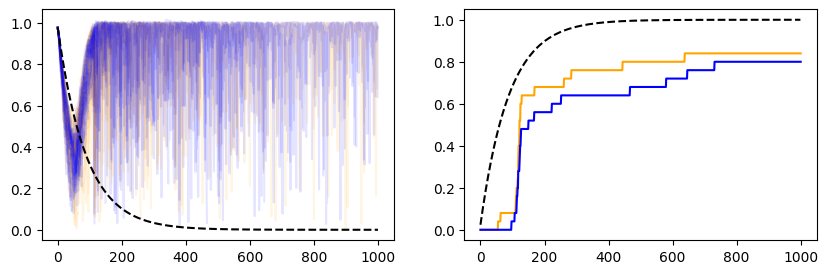

In [34]:
plot_results(25)

0.00229702 1.4181306
xy list:  [[(0.004593944642692804, 1.4247629642486572), (0.007393360137939453, 1.4318108558654785), (0.01002426166087389, 1.4379644393920898), (0.01209268532693386, 1.4414279460906982), (0.014352512545883656, 1.4464994668960571), (0.016539668664336205, 1.4503285884857178), (0.017329026013612747, 1.4531599283218384), (0.019389629364013672, 1.4553638696670532), (0.02146759070456028, 1.4589393138885498), (0.023260021582245827, 1.4611639976501465)], [(0.04609937593340874, 1.4373340606689453), (0.048792459070682526, 1.4324485063552856), (0.050485897809267044, 1.426101803779602), (0.05244093015789986, 1.4188966751098633), (0.05468177795410156, 1.411692500114441), (0.05700063705444336, 1.4041337966918945), (0.059031009674072266, 1.3953287601470947), (0.0609431266784668, 1.3852930068969727), (0.0627984032034874, 1.3750606775283813), (0.06440725177526474, 1.3634603023529053)], [(0.0843936949968338, 1.2052158117294312), (0.08585691452026367, 1.1875393390655518), (0.087385848

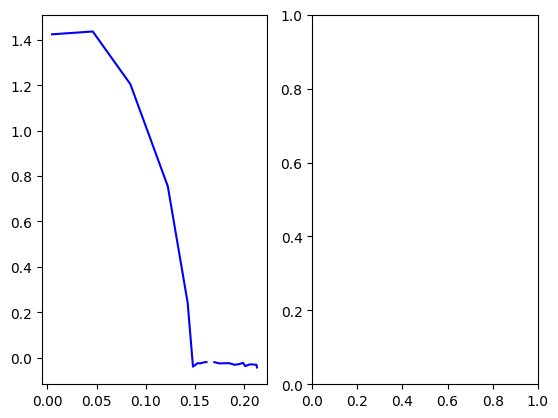

([[(0.004593944642692804, 1.4247629642486572),
   (0.007393360137939453, 1.4318108558654785),
   (0.01002426166087389, 1.4379644393920898),
   (0.01209268532693386, 1.4414279460906982),
   (0.014352512545883656, 1.4464994668960571),
   (0.016539668664336205, 1.4503285884857178),
   (0.017329026013612747, 1.4531599283218384),
   (0.019389629364013672, 1.4553638696670532),
   (0.02146759070456028, 1.4589393138885498),
   (0.023260021582245827, 1.4611639976501465)],
  [(0.04609937593340874, 1.4373340606689453),
   (0.048792459070682526, 1.4324485063552856),
   (0.050485897809267044, 1.426101803779602),
   (0.05244093015789986, 1.4188966751098633),
   (0.05468177795410156, 1.411692500114441),
   (0.05700063705444336, 1.4041337966918945),
   (0.059031009674072266, 1.3953287601470947),
   (0.0609431266784668, 1.3852930068969727),
   (0.0627984032034874, 1.3750606775283813),
   (0.06440725177526474, 1.3634603023529053)],
  [(0.0843936949968338, 1.2052158117294312),
   (0.08585691452026367, 1.

In [70]:
def title_plot(num_agents=100, time_steps=1000):
    state0, _ = env.env.reset(seed=42)
    state0_copy = state0
    x0, y0 = state0[0], state0[1]
    print(state0[0], state0[1])
    xy_list = []
    xyc_cbf_list = []
    for i in range(num_agents):
        local_xy_list = []
        local_xyc_cbf_list = []
        for t in range(time_steps):
            # no cbf
            state_old = state0
            action = policy.select_action(torch.tensor(state_old, dtype=torch.float32), exploration=False)
            state_new, reward, terminated, truncated, _ = env.env.step(action.squeeze().detach().numpy())
            xy = (state_new[0].item(), state_new[1].item())
            local_xy_list.append(xy)
            state0 = state_new
        xy_list.append(local_xy_list)
        local_xy_list = []
        
        

        infeasibility_counter = 0
        for t in range(time_steps):    
            # cbf

            state_cbf_old = state0_copy
            
            # follow original actor if no feasible safe action exists
            try:
                action = cbf.safe_action(torch.tensor(state_cbf_old, dtype=torch.float32))
            except InfeasibilityError:
                action = policy.select_action(torch.tensor(state_cbf_old, dtype=torch.float32), exploration=False)
                infeasibility_counter += 1
            state_cbf_new = env.env.step(action.squeeze().detach().numpy())
            xyc_cbf = (state_cbf_new[0][0], state_cbf_new[0][1], infeasibility_counter)
            state_cbf_old = state_cbf_new
            local_xyc_cbf_list.append(xyc_cbf)
            
        xyc_cbf_list.append(local_xyc_cbf_list)
        local_xyc_cbf_list = []
        
    print("xy list: ", xy_list)   
    fig, axs = plt.subplots(nrows=1, ncols=2)
    xs = [xy_list[i][0][0] for i in range(len(xy_list))]
    ys = [xy_list[i][0][1] for i in range(len(xy_list))]    
    print("XS, YS")
    print(xs, ys)
    
    for n in range(num_agents):
        x = xs[n*time_steps : time_steps*(n + 1)]
        y = ys[n*time_steps : time_steps*(n + 1)]
        print("the current agent is: ", n, "with x list: {}, y list: {}".format(x, y))
        axs[0].plot(x, y, color='blue')
        
    plt.show()
    return xy_list, xyc_cbf_list
            
            
    
title_plot(20, 10)